## Sử dụng thêm thuộc tính sư chênh lệch giá giữa 2 ngày liền nhau

In [1]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

import yfinance as yf

from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('data/close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
df.head()

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2018-12-31,157.740005,1044.959961,101.570000,1501.969971,131.089996
2019-01-02,157.919998,1054.680054,101.120003,1539.130005,135.679993
2019-01-03,142.190002,1025.469971,97.400002,1500.280029,131.740005
2019-01-04,148.259995,1078.069946,101.930000,1575.390015,137.949997
2019-01-07,147.929993,1075.920044,102.059998,1629.510010,138.050003


## lấy giá chênh lệch

In [43]:
def get_diff(df, history=1):
    diff = []
    df = df.to_numpy()

    for i in range(history, len(df)):
        diff.append(df[i] - df[i-history])
        
    return np.array(diff)

In [45]:
cr = get_diff(df)
print(cr.shape)

(334, 5)


In [46]:
cr_aapl = get_diff(df['AAPL'])
print(type(cr_aapl))

<class 'numpy.ndarray'>


In [47]:
cr_msft = get_diff(df['MSFT'])
print(len(cr_msft))

334


In [48]:
cr_fb = get_diff(df['FB'], history=1)
print(len(cr_fb))

334


In [49]:
cr_googl = get_diff(df['GOOGL'], history=1)
print(len(cr_googl))

334


In [50]:
cr_amzn = get_diff(df['AMZN'], history=1)
print(type(cr_amzn))

<class 'numpy.ndarray'>


In [51]:
cr_aapl = np.array(cr_aapl).reshape((-1,1))
cr_googl = np.array(cr_googl).reshape((-1,1))
cr_msft = np.array(cr_msft).reshape((-1,1))
cr_amzn = np.array(cr_amzn).reshape((-1,1))
cr_fb = np.array(cr_fb).reshape((-1,1))

cr_low = (cr_aapl+cr_fb+cr_msft)/3
cr_high = (cr_amzn+cr_googl)/2
print((cr_low.shape))

(334, 1)


## tạo dữ liệu train - test cho 1 công ty. X=5 ngày trước & sự thay đổi giữa các ngày

In [52]:
def create_Xy(df, code, history=2):
    '''df has index as date
    columns are stock price of the companies
    '''
    cr = get_diff(df[code])
    X1, X2, y, dates = [], [], [], []
    for row_idx in range(history, len(df)):
        X1.append( cr[row_idx-history:row_idx-1] )
        X2.append( df[code].iloc[row_idx-history:row_idx].values.reshape(-1) )
        
        y.append( df[code].iloc[row_idx].reshape(-1) )
        dates.append(df.index[row_idx])
    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    X = np.hstack((X1,X2))
    return X, y, dates

In [53]:
code = 'AAPL'
X,y,dates = create_Xy(df, code, history=5)

In [54]:
print(X.shape)
print(y.shape)

(330, 9)
(330, 1)


In [55]:
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

## Linear Regression model

In [56]:
clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)

## plot prediction

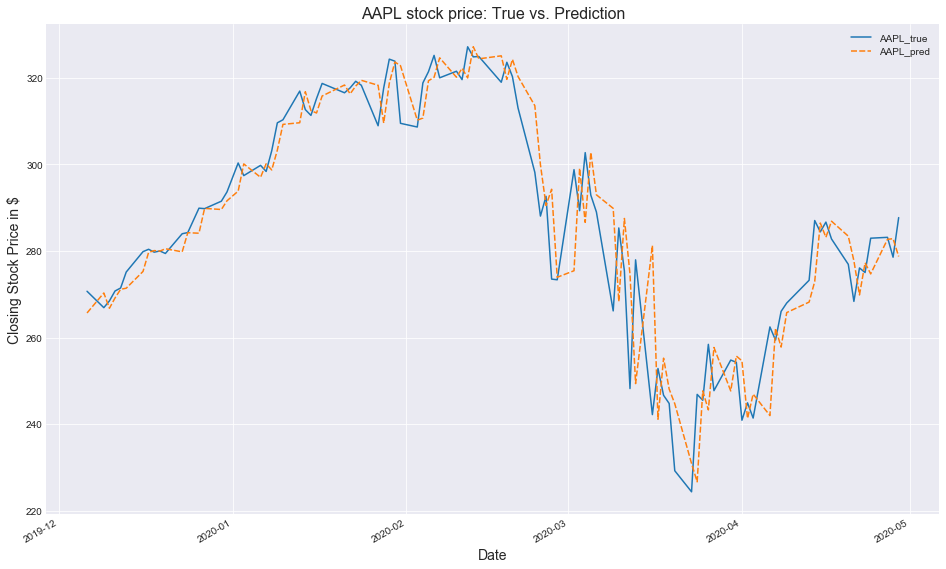

In [57]:
df_plot = pd.DataFrame({"AAPL_true": y_test.reshape(-1)[:], 'AAPL_pred': ypred.reshape(-1)[:]}, index=dates_test[:])

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title(code + ' stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

## Đánh giá kết quả:

In [58]:
from sklearn.metrics import mean_squared_error

def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

print(code, mean_relative_error(y_test.reshape(-1), ypred.reshape(-1)))

AAPL 0.024700108227584734


In [72]:
code = 'GOOGL'
X,y,dates = create_Xy(df, code, history=5)

# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)

print(code, mean_relative_error(y_test.reshape(-1), ypred.reshape(-1)))

GOOGL 0.022573133118836904


In [71]:
code = 'MSFT'
X,y,dates = create_Xy(df, code, history=5)

# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)

print(code, mean_relative_error(y_test.reshape(-1), ypred.reshape(-1)))

MSFT 0.024505116056252222


In [61]:
code = 'AMZN'
X,y,dates = create_Xy(df, code, history=5)

# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)

def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

print(code, mean_relative_error(y_test.reshape(-1), ypred.reshape(-1)))

AMZN 0.01933552776497684


In [70]:
code = 'FB'
X,y,dates = create_Xy(df, code, history=5)

# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)

print(code, mean_relative_error(y_test.reshape(-1), ypred.reshape(-1)))

FB 0.02377975770813905


## So sánh với việc chỉ lấy giá stock của 5 ngày trước: Mean relative error của Facebook bé hơn ~1.1%. Các công ty còn lại thì gần tương đương.

## fit dữ liệu của cả 5 công ty cùng lúc:

In [66]:
def create_Xy_all(df, history=2):
    '''df has index as date
    columns are stock price of the companies
    '''
    cr = get_diff(df)

    X1, X2, y, dates = [], [], [], []
    for row_idx in range(history, len(df)):
        X1.append( cr[row_idx-history:row_idx-1, :].reshape(-1) )
        X2.append( df.iloc[row_idx-history:row_idx, :].values.reshape(-1) )
        
        y.append( df.iloc[row_idx,:].values.reshape(-1) )
        dates.append(df.index[row_idx])
    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    X = np.hstack((X1,X2))
    return X, y, dates

In [78]:
X, y, dates = create_Xy_all(df, history=5)
print(X.shape)
print(y.shape)

(330, 45)
(330, 5)


In [79]:
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

In [81]:
clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)


for i in range(5):
    print(df.columns[i], mean_relative_error(y_test[:,i], ypred[:,i]))

AAPL 0.023751767727776246
GOOGL 0.02242385214740589
MSFT 0.025059218057111983
AMZN 0.018868067570525088
FB 0.03552132412974315
